In [321]:
import strax
import straxen
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [374]:
st = straxen.contexts.xenon1t_dali()
rr_noise = st.get_array('180219_0946','raw_records', seconds_range=(0, 0.1))
rr = st.get_array('180215_1035','raw_records', seconds_range=(0, 0.1))

In [375]:
st.data_info('raw_records')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,pulse_length,int32,Length of pulse to which the record belongs (w...
5,record_i,int16,Fragment number in the pulse
6,baseline,int16,Baseline determined by the digitizer (if this ...
7,data,"('<i2', (110,))",Waveform data in raw ADC counts


In [376]:
rr[0]

(1518690942000126790, 104, 10, 113, 104, 0, 0, [16008, 16016, 16009, 16013, 16003, 16012, 16005, 16008, 15999, 16008, 16002, 16009, 16000, 16009, 16004, 16014, 16004, 16012, 16006, 16015, 16009, 16015, 16005, 16013, 16005, 16013, 16006, 16008, 16002, 16005, 16001, 16010, 16007, 16011, 16003, 16009, 16005, 16014, 16008, 16015, 16007, 16012, 16008, 16014, 16008, 16011, 16003, 16010, 16003, 16008, 15982, 15938, 15976, 16003, 16000, 16007, 16002, 16012, 16004, 16012, 16006, 16012, 16005, 16010, 16001, 16011, 16002, 16007, 16001, 16008, 16003, 16008, 16001, 16009, 16004, 16011, 16006, 16014, 16007, 16014, 16006, 16010, 16004, 16011, 16006, 16012, 16006, 16010, 16003, 16007, 16002, 16009, 16003, 16009, 16003, 16012, 16008, 16014, 16008, 16013, 16004, 16011, 16005, 16013,     0,     0,     0,     0,     0,     0])

In [377]:
record = strax.raw_to_records(rr)
record_noise = strax.raw_to_records(rr_noise)

strax.baseline(record)
strax.baseline(record_noise)

#Here we define two variables, sample noise and sample data, representing the 0th sample of noise recordings in
#channel 0 and the 0th sample of signal recordings in channel 0. 
sample_noise = record_noise[0]
sample_data = record[record["channel"] == 0][0]


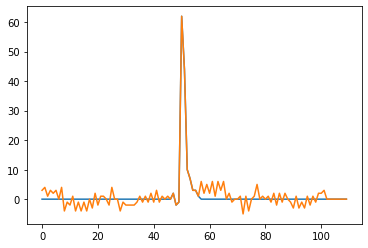

In [382]:
ft = scipy.ndimage.filters.gaussian_filter1d(sample_data[-1], 3*np.std(sample_noise[-1]))

#After filtering, we locates the peaks in the remaining signal. By now all noise terms should already be 
#eliminated. Therefore the leftover peaks should be the location of the pulses. 
peaks, _ = signal.find_peaks(ft)

#Now we keep the 5 nearest neighbors of each peak, and set the rest of the signal to be 0, where we think 
#are positions of noises. 
result = [0]*110
for peak in peaks:
    result[peak-5:peak+5] = sample_data[-1][peak-5:peak+5]

#Let's plot them and see results. 
plt.plot(result)
plt.plot(sample_data[-1])

25


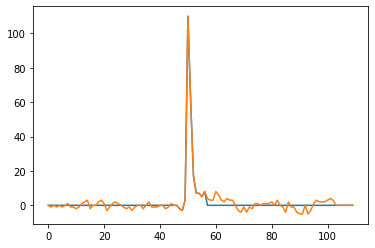

In [383]:
import random
ch0 = record[record["channel"] == 0]
ran_index = random.randrange(0, len(ch0))
#print (ran_index)

ft_new = scipy.ndimage.filters.gaussian_filter1d(ch0[ran_index][-1], 3*np.std(sample_noise[-1]))
peaks, _ = signal.find_peaks(ft_new)

result = np.array([0]*110)
for peak in peaks:
    result[peak-5:peak+5] = ch0[ran_index][-1][peak-5:peak+5]

plt.plot(result)
plt.plot(ch0[ran_index][-1])

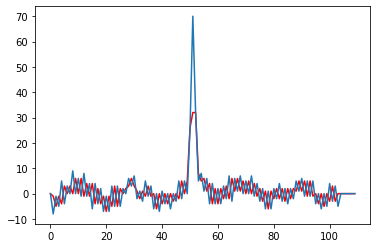

In [386]:
#Firstly we are going to implement a median filter:
from scipy.signal import medfilt
#taking record[0] as an example
med_filtered_example = medfilt(record[0][-1])
plt.plot(med_filtered_example,color="red")
plt.plot(record[0][-1])
plt.show()

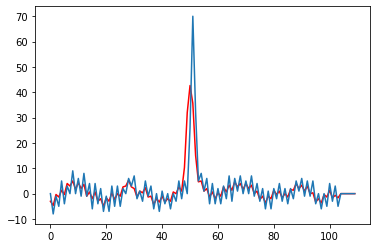

In [387]:
#Now let's implement a simple mean filter:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]
plt.plot(runningMeanFast(record[0][-1], 3), color="red")
plt.plot(record[0][-1])
plt.show()

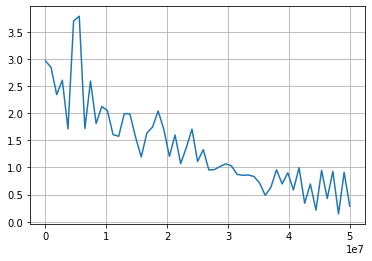

In [116]:
from scipy import signal
from scipy.fft import fft
from scipy.signal import butter, lfilter

N = 110
# sample spacing
T = 1e-8
x = np.linspace(0.0, N*T, N)
sample = record[0][-1]
yf = fft(sample)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

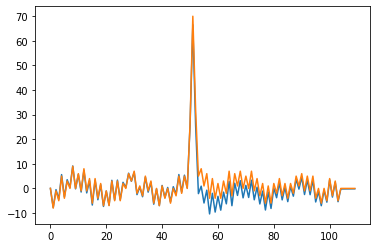

In [389]:
fs = 1e8 
cutoff = 0.1e7 # 10 MHz
B, A = butter(1, cutoff / (fs / 2), btype='high') # 1st order Butterworth low-pass
filtered_signal = lfilter(B, A, record[0][-1], axis=0)
plt.plot(filtered_signal)
plt.plot(record[0][-1])
plt.show()

/home/shuaichengli0428/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/shuaichengli0428/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:1456: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


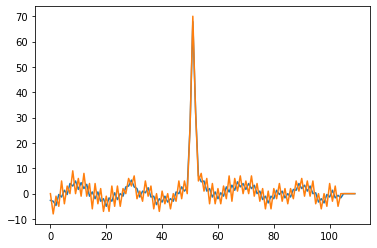

In [393]:
w_filtered = signal.wiener(record[0][-1])
plt.plot(w_filtered) #filtered
plt.plot(record[0][-1]) #original signal

In [395]:
%%time
def wiener_filter(record):
    cp = record.copy()
    for item in cp:
        Wiener_filtered = signal.wiener(item[-1])
        item[-1] = Wiener_filtered
    return cp

record_filtered = wiener_filter(record)

CPU times: user 2.07 s, sys: 19.3 ms, total: 2.09 s
Wall time: 2.07 s
